In [10]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'


from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import (GridSearchCV, StratifiedKFold,
                                     cross_val_score)
from sklearn.preprocessing import PolynomialFeatures

In [4]:
class LogReg:
    def __init__(self, tolerance=0.001, learning_rate=0.01, l1=0.0):
        self.learning_rate = learning_rate
        self.tolerance = tolerance
        
    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X_train, y_train):
        n_samples, n_features = X_train.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        prev_dw = np.ones(n_features) * self.tolerance * 2
        prev_db = self.tolerance * 2

        while np.abs(prev_db) > self.tolerance or (np.abs(prev_dw) > self.tolerance).any():
            linear_model = X_train @ self.weights + self.bias
            y_pred = self.sigmoid(linear_model)
            
            error = y_pred - y_train
            
            dw = (1 / n_samples) * X_train.T @ error
            db = (1 / n_samples) * np.sum(error)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            prev_dw = dw
            prev_db = db
            
    def predict_proba(self, X_test):
        linear_model = X_test @ self.weights + self.bias
        return self.sigmoid(linear_model)

    def predict(self, X_test, threshold=0.5):
        proba = self.predict_proba(X_test)
        return (proba >= threshold).astype(int)

In [5]:
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/"
data = pd.read_csv(
    DATA_PATH + "microchip_tests.txt",
    header=None,
    names=("test1", "test2", "released")
)

data.head()

,test1,test2,released
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [6]:
X = data.iloc[:, :2].values
y = data.iloc[:, 2].values

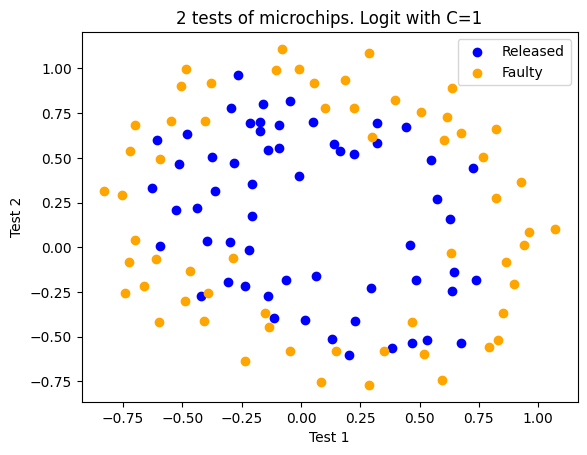

In [7]:
plt.scatter(X[y == 1, 0], X[y == 1, 1], c="blue", label="Released")
plt.scatter(X[y == 0, 0], X[y == 0, 1], c="orange", label="Faulty")
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title("2 tests of microchips. Logit with C=1")
plt.legend();

In [17]:
def plot_boundary(clf, X, y, grid_step=0.01):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, grid_step),
        np.arange(y_min, y_max, grid_step)
    )

    grid = np.c_[xx.ravel(), yy.ravel()]
    
    Z = clf.predict(grid)
    Z = Z.reshape(xx.shape)

    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

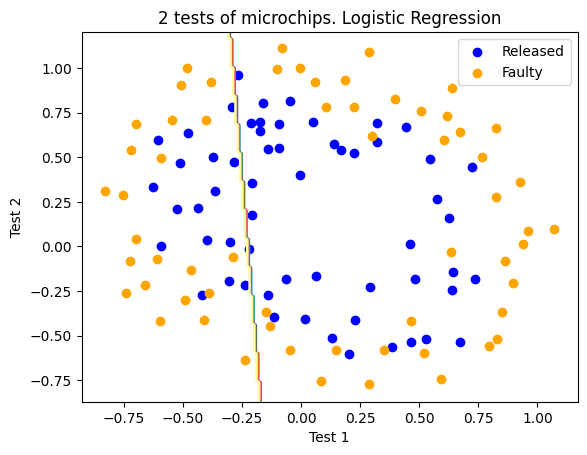

Accuracy on training set: 0.466


In [20]:
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)

model = LogReg(learning_rate=5, tolerance=1e-5)
model.fit(X_scaled, y)


plot_boundary(model, X, y, grid_step=0.01)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c="blue", label="Released")
plt.scatter(X[y == 0, 0], X[y == 0, 1], c="orange", label="Faulty")
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title("2 tests of microchips. Logistic Regression")
plt.legend()
plt.show()

print("Accuracy on training set:", round(model.predict(X_scaled).mean(), 3))

In [9]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=2, cluster_std=2, random_state=42)

X = StandardScaler().fit_transform(X)

model = LogReg(learning_rate=0.1, tolerance=1e-5)
model.fit(X, y)

preds = model.predict(X)
acc = (preds == y).mean()
print("Accuracy:", acc)

Accuracy: 0.9933333333333333


In [8]:
def plot_boundary_poly(clf, X, y, grid_step=0.01, poly_featurizer=None):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, grid_step), np.arange(y_min, y_max, grid_step)
    )

    Z = clf.predict(poly_featurizer.transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

In [11]:
poly = PolynomialFeatures(degree=7)
X_poly = poly.fit_transform(X)

X_poly.shape

(118, 36)

Accuracy on training set: 0.627


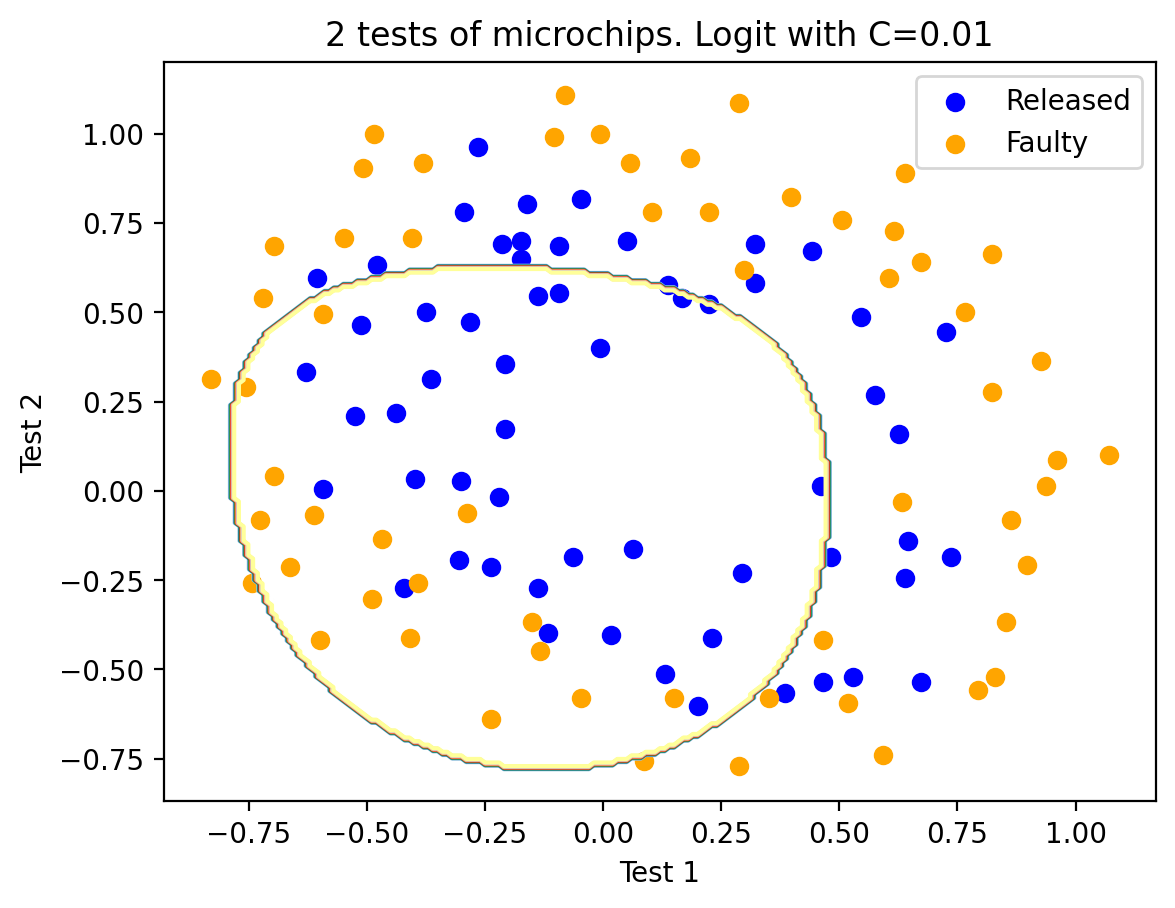

In [13]:
C = 1e-2
logit = LogisticRegression(C=C, random_state=17)
logit.fit(X_poly, y)

plot_boundary_poly(logit, X, y, grid_step=0.01, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c="blue", label="Released")
plt.scatter(X[y == 0, 0], X[y == 0, 1], c="orange", label="Faulty")
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title("2 tests of microchips. Logit with C=%s" % C)
plt.legend()

print("Accuracy on training set:", round(logit.score(X_poly, y), 3))

Accuracy on training set: 0.831


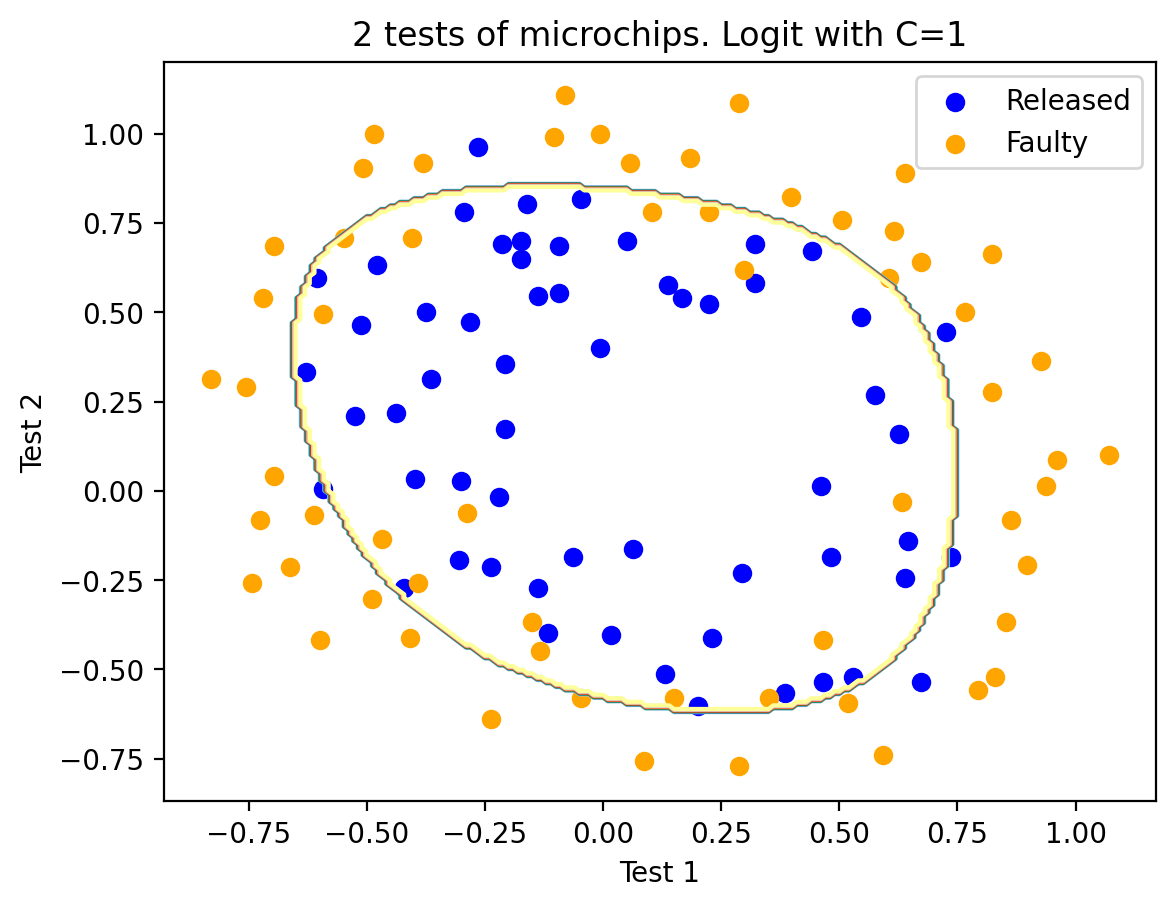

In [14]:
C = 1
logit = LogisticRegression(C=C, random_state=17)
logit.fit(X_poly, y)

plot_boundary_poly(logit, X, y, grid_step=0.01, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c="blue", label="Released")
plt.scatter(X[y == 0, 0], X[y == 0, 1], c="orange", label="Faulty")
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title("2 tests of microchips. Logit with C=%s" % C)
plt.legend()

print("Accuracy on training set:", round(logit.score(X_poly, y), 3))

In [15]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

c_values = np.logspace(-2, 3, 500)

logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, n_jobs=-1)
logit_searcher.fit(X_poly, y)

logit_searcher.C_

array([157.90533145])

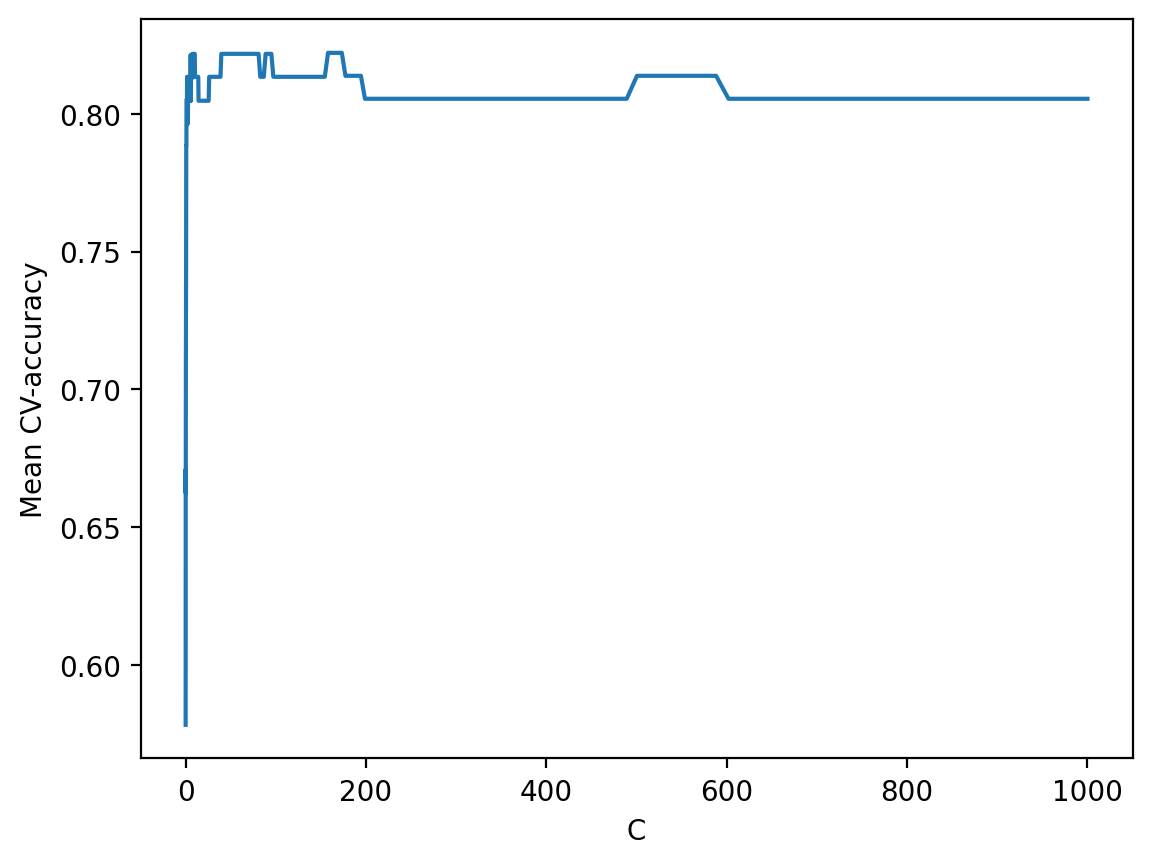

In [16]:
plt.plot(c_values, np.mean(logit_searcher.scores_[1], axis=0))
plt.xlabel("C")
plt.ylabel("Mean CV-accuracy");